## DRAGON *DualFinder*: An Instance of the DRAGON CNN Architecture Specialized for Dual AGN Detection.
### Authors: Isaac Moskowitz and Jeremy Ng
### Collaborators: C. Meg Urry (PI), Aritra Ghosh. 
#### Began June 7, 2024


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
import logging
import pandas as pd
import csv
import sys
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score 
from keras import backend as K
import os
#import tensorflow_addons as tfa
import shutil
#from dual_finder import DualFinder, loadModelClass
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(tf.config.list_physical_devices())
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
from astropy.io import fits

sys.path.append("DRAGON_Dual_Finder/dual_finder/cnn/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/optimize/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/preprocess_data/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/visualize/")
from create_cnn import ModelCreator
from load_model import loadModelClass
from train_cnn import DualFinder
from extract_feature_maps import FeatureExtractor
from fits_utils import plot_dataset_sample
from process_data import make_datasets_other_bands, create_dataset
from optimize_hyperparameters import OptimizeHyperparameters
from visualize_performance import load_training_history, plot_training_progress, plot_grouped_training_progress, VisualizeOptimization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU is available
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10248108084479288856
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10086383616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3947788101680040897
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2024-06-10 16:00:16.699369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 9619 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [7]:
#os.chdir("~/")
#!pwd
empty_sky_filepath = "data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/"
single_AGN_filepath = "data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/"
dual_AGN_filepath = "data_preprocessing/training_datasets/dual_AGN_datasets/train_data/"
offset_AGN_filepath = 'data_preprocessing/training_datasets/offset_AGN_datasets/train_data/'
stellar_filepath = "data_preprocessing/training_datasets/stellar_dataset/"
train_data_labels, val_data_labels, test_data_labels = create_dataset(empty_sky_filepath, single_AGN_filepath, dual_AGN_filepath, offset_AGN_filepath, stellar_filepath)
train_dataset, train_labels = train_data_labels
val_dataset, val_labels = val_data_labels
test_dataset, test_labels = test_data_labels


2024-06-10 16:34:22,630 - INFO - Loading empty sky images...
100%|██████████| 9215/9215 [00:19<00:00, 461.17it/s]
9215it [00:50, 181.83it/s]
2024-06-10 16:35:34,870 - INFO - Loading single AGN images...


Shape of empty_sky_images: (36860, 94, 94, 1)


100%|██████████| 2000/2000 [00:03<00:00, 506.58it/s]
2000it [00:36, 54.60it/s]
2024-06-10 16:36:16,467 - INFO - Loading dual AGN images...
 61%|██████    | 17229/28426 [00:24<00:15, 724.70it/s]

data_preprocessing/training_datasets/dual_AGN_datasets/train_data/20_with_AGN_345.fits is corrupted or empty, moving on...


100%|██████████| 28426/28426 [00:40<00:00, 709.54it/s]
2024-06-10 16:36:57,069 - INFO - Loading offset AGN images
100%|██████████| 28756/28756 [00:43<00:00, 657.78it/s]
2024-06-10 16:37:41,337 - INFO - Loading stellar images
100%|██████████| 368/368 [00:01<00:00, 240.85it/s]
368it [00:06, 53.49it/s]


Total images: (120089, 94, 94, 1)
Total labels: (120089,)


In [13]:
print(np.shape(val_dataset))
print(np.shape(val_labels))

(23208, 94, 94, 1)
(23208,)


In [14]:
image_shape = (94,94,1)
epoch = 30
batch_size = 64
init_learning_rate = 1e-5
num_classes = 5
model_type = 'dualfinder'


dual_finder_instance = DualFinder(train_dataset, val_dataset, image_shape, train_labels, val_labels, epoch, batch_size, init_learning_rate, num_classes, model_type, display_architecture = True)
history, dual_finder_model = dual_finder_instance.trainCNN(save_feature_maps = False)

['offset_AGN' 'dual_AGN' 'empty_sky' ... 'offset_AGN' 'single_AGN'
 'single_AGN']
['empty_sky' 'dual_AGN' 'empty_sky' ... 'offset_AGN' 'empty_sky'
 'single_AGN']
Converting to list
Converting to list
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 94, 94, 1)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 64)        640       
                                                                 
 dropout_8 (Dropout)         (None, 47, 47, 64)        0         
                                                                 
 batch_normalization_7 (Bat  (None, 47, 47, 64)        256       
 chNormalization)                                                
                                                                 
 average_pooling2d_3 (Avera  (None, 23, 23, 64)     

2024-06-10 14:22:04,919 - INFO - 'save_feature_maps' == False, NOT saving feature maps


Epoch 1/30


2024-06-10 14:22:07.965339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:22:20,638 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 14s - loss: 20.7688 - accuracy: 0.7628 - recall: 0.6650 - precision: 0.8530 - f1_score: 0.7384 - val_loss: 18.7220 - val_accuracy: 0.9067 - val_recall: 0.9026 - val_precision: 0.9100 - val_f1_score: 0.8948 - 14s/epoch - 12ms/step
Epoch 2/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:22:30,752 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 16.9737 - accuracy: 0.9115 - recall: 0.9057 - precision: 0.9169 - f1_score: 0.9027 - val_loss: 15.2240 - val_accuracy: 0.9217 - val_recall: 0.9200 - val_precision: 0.9236 - val_f1_score: 0.9139 - 10s/epoch - 9ms/step
Epoch 3/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:22:40,692 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 13.6198 - accuracy: 0.9334 - recall: 0.9301 - precision: 0.9368 - f1_score: 0.9263 - val_loss: 12.1127 - val_accuracy: 0.9334 - val_recall: 0.9330 - val_precision: 0.9338 - val_f1_score: 0.9241 - 10s/epoch - 8ms/step
Epoch 4/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:22:51,110 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 10.7009 - accuracy: 0.9460 - recall: 0.9434 - precision: 0.9488 - f1_score: 0.9400 - val_loss: 9.3750 - val_accuracy: 0.9612 - val_recall: 0.9608 - val_precision: 0.9622 - val_f1_score: 0.9560 - 10s/epoch - 9ms/step
Epoch 5/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:23:01,191 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 8.2825 - accuracy: 0.9545 - recall: 0.9527 - precision: 0.9567 - f1_score: 0.9493 - val_loss: 7.2271 - val_accuracy: 0.9698 - val_recall: 0.9698 - val_precision: 0.9701 - val_f1_score: 0.9658 - 10s/epoch - 9ms/step
Epoch 6/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:23:11,157 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 6.3747 - accuracy: 0.9605 - recall: 0.9591 - precision: 0.9620 - f1_score: 0.9558 - val_loss: 5.5507 - val_accuracy: 0.9698 - val_recall: 0.9695 - val_precision: 0.9700 - val_f1_score: 0.9656 - 10s/epoch - 8ms/step
Epoch 7/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:23:21,488 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 4.9218 - accuracy: 0.9656 - recall: 0.9643 - precision: 0.9670 - f1_score: 0.9616 - val_loss: 4.3198 - val_accuracy: 0.9696 - val_recall: 0.9695 - val_precision: 0.9701 - val_f1_score: 0.9655 - 10s/epoch - 9ms/step
Epoch 8/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:23:31,505 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 3.8507 - accuracy: 0.9690 - recall: 0.9679 - precision: 0.9699 - f1_score: 0.9653 - val_loss: 3.3949 - val_accuracy: 0.9784 - val_recall: 0.9776 - val_precision: 0.9790 - val_f1_score: 0.9758 - 10s/epoch - 9ms/step
Epoch 9/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:23:42,009 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 3.0640 - accuracy: 0.9728 - recall: 0.9721 - precision: 0.9736 - f1_score: 0.9696 - val_loss: 2.7292 - val_accuracy: 0.9756 - val_recall: 0.9752 - val_precision: 0.9764 - val_f1_score: 0.9723 - 10s/epoch - 9ms/step
Epoch 10/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:23:52,071 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 2.4849 - accuracy: 0.9754 - recall: 0.9747 - precision: 0.9760 - f1_score: 0.9726 - val_loss: 2.2230 - val_accuracy: 0.9865 - val_recall: 0.9860 - val_precision: 0.9868 - val_f1_score: 0.9848 - 10s/epoch - 9ms/step
Epoch 11/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:24:02,058 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 2.0540 - accuracy: 0.9777 - recall: 0.9772 - precision: 0.9785 - f1_score: 0.9751 - val_loss: 1.9694 - val_accuracy: 0.9525 - val_recall: 0.9524 - val_precision: 0.9528 - val_f1_score: 0.9455 - 10s/epoch - 8ms/step
Epoch 12/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:24:12,480 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 1.7285 - accuracy: 0.9803 - recall: 0.9797 - precision: 0.9809 - f1_score: 0.9781 - val_loss: 1.5779 - val_accuracy: 0.9828 - val_recall: 0.9828 - val_precision: 0.9829 - val_f1_score: 0.9804 - 10s/epoch - 9ms/step
Epoch 13/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:24:22,611 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 1.4768 - accuracy: 0.9824 - recall: 0.9818 - precision: 0.9829 - f1_score: 0.9804 - val_loss: 1.3726 - val_accuracy: 0.9829 - val_recall: 0.9820 - val_precision: 0.9834 - val_f1_score: 0.9814 - 10s/epoch - 9ms/step
Epoch 14/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:24:32,941 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 1.2802 - accuracy: 0.9840 - recall: 0.9836 - precision: 0.9844 - f1_score: 0.9822 - val_loss: 1.2712 - val_accuracy: 0.9559 - val_recall: 0.9548 - val_precision: 0.9574 - val_f1_score: 0.9539 - 10s/epoch - 9ms/step
Epoch 15/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:24:42,954 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 1.1218 - accuracy: 0.9858 - recall: 0.9855 - precision: 0.9861 - f1_score: 0.9842 - val_loss: 1.4351 - val_accuracy: 0.8609 - val_recall: 0.8545 - val_precision: 0.8712 - val_f1_score: 0.8346 - 10s/epoch - 8ms/step
Epoch 16/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:24:53,035 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.9938 - accuracy: 0.9863 - recall: 0.9860 - precision: 0.9865 - f1_score: 0.9848 - val_loss: 0.9370 - val_accuracy: 0.9864 - val_recall: 0.9858 - val_precision: 0.9868 - val_f1_score: 0.9856 - 10s/epoch - 9ms/step
Epoch 17/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:25:03,401 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.8908 - accuracy: 0.9875 - recall: 0.9872 - precision: 0.9878 - f1_score: 0.9861 - val_loss: 0.8329 - val_accuracy: 0.9931 - val_recall: 0.9927 - val_precision: 0.9934 - val_f1_score: 0.9928 - 10s/epoch - 9ms/step
Epoch 18/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:25:13,415 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.8020 - accuracy: 0.9880 - recall: 0.9878 - precision: 0.9882 - f1_score: 0.9867 - val_loss: 0.7529 - val_accuracy: 0.9905 - val_recall: 0.9905 - val_precision: 0.9905 - val_f1_score: 0.9892 - 10s/epoch - 8ms/step
Epoch 19/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:25:23,727 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.7280 - accuracy: 0.9892 - recall: 0.9889 - precision: 0.9895 - f1_score: 0.9881 - val_loss: 0.7049 - val_accuracy: 0.9857 - val_recall: 0.9853 - val_precision: 0.9864 - val_f1_score: 0.9842 - 10s/epoch - 9ms/step
Epoch 20/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:25:33,762 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.6634 - accuracy: 0.9907 - recall: 0.9906 - precision: 0.9909 - f1_score: 0.9898 - val_loss: 0.6342 - val_accuracy: 0.9888 - val_recall: 0.9888 - val_precision: 0.9889 - val_f1_score: 0.9872 - 10s/epoch - 9ms/step
Epoch 21/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:25:43,828 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.6113 - accuracy: 0.9902 - recall: 0.9900 - precision: 0.9905 - f1_score: 0.9893 - val_loss: 0.5717 - val_accuracy: 0.9956 - val_recall: 0.9955 - val_precision: 0.9956 - val_f1_score: 0.9954 - 10s/epoch - 9ms/step
Epoch 22/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:25:54,266 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.5632 - accuracy: 0.9914 - recall: 0.9913 - precision: 0.9916 - f1_score: 0.9906 - val_loss: 0.5233 - val_accuracy: 0.9978 - val_recall: 0.9978 - val_precision: 0.9978 - val_f1_score: 0.9977 - 10s/epoch - 9ms/step
Epoch 23/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:26:04,412 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.5242 - accuracy: 0.9913 - recall: 0.9911 - precision: 0.9916 - f1_score: 0.9905 - val_loss: 0.4885 - val_accuracy: 0.9972 - val_recall: 0.9972 - val_precision: 0.9973 - val_f1_score: 0.9971 - 10s/epoch - 9ms/step
Epoch 24/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:26:14,900 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.4876 - accuracy: 0.9922 - recall: 0.9921 - precision: 0.9924 - f1_score: 0.9915 - val_loss: 0.4598 - val_accuracy: 0.9963 - val_recall: 0.9962 - val_precision: 0.9964 - val_f1_score: 0.9963 - 10s/epoch - 9ms/step
Epoch 25/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:26:25,018 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.4552 - accuracy: 0.9927 - recall: 0.9925 - precision: 0.9928 - f1_score: 0.9919 - val_loss: 0.4284 - val_accuracy: 0.9972 - val_recall: 0.9972 - val_precision: 0.9973 - val_f1_score: 0.9973 - 10s/epoch - 9ms/step
Epoch 26/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:26:35,103 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.4261 - accuracy: 0.9935 - recall: 0.9933 - precision: 0.9936 - f1_score: 0.9929 - val_loss: 0.4383 - val_accuracy: 0.9854 - val_recall: 0.9851 - val_precision: 0.9855 - val_f1_score: 0.9830 - 10s/epoch - 9ms/step
Epoch 27/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:26:45,531 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.4016 - accuracy: 0.9936 - recall: 0.9935 - precision: 0.9938 - f1_score: 0.9930 - val_loss: 0.3778 - val_accuracy: 0.9981 - val_recall: 0.9981 - val_precision: 0.9981 - val_f1_score: 0.9981 - 10s/epoch - 9ms/step
Epoch 28/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:26:55,668 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.3798 - accuracy: 0.9935 - recall: 0.9934 - precision: 0.9938 - f1_score: 0.9929 - val_loss: 0.3600 - val_accuracy: 0.9966 - val_recall: 0.9966 - val_precision: 0.9966 - val_f1_score: 0.9966 - 10s/epoch - 9ms/step
Epoch 29/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:27:05,742 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.3567 - accuracy: 0.9944 - recall: 0.9942 - precision: 0.9945 - f1_score: 0.9939 - val_loss: 0.4058 - val_accuracy: 0.9758 - val_recall: 0.9744 - val_precision: 0.9769 - val_f1_score: 0.9723 - 10s/epoch - 9ms/step
Epoch 30/30
INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-10 14:27:16,089 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


1179/1179 - 10s - loss: 0.3383 - accuracy: 0.9947 - recall: 0.9946 - precision: 0.9947 - f1_score: 0.9942 - val_loss: 0.3177 - val_accuracy: 0.9987 - val_recall: 0.9986 - val_precision: 0.9987 - val_f1_score: 0.9987 - 10s/epoch - 9ms/step


/home/iam37/.conda/envs/DualFinder/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
eval_labels_encoded, _ = dual_finder_instance.encode_labels(test_labels, test_labels)
dual_finder_model.evaluate(test_dataset, eval_labels_encoded, batch_size = batch_size, verbose = 1)

['offset_AGN' 'empty_sky' 'empty_sky' ... 'offset_AGN' 'empty_sky'
 'empty_sky']
['offset_AGN' 'empty_sky' 'empty_sky' ... 'offset_AGN' 'empty_sky'
 'empty_sky']
Converting to list
Converting to list
272/272 [==============================] - 1s 3ms/step - loss: 0.3175 - accuracy: 0.9983 - recall: 0.9982 - precision: 0.9984 - f1_score: 0.9982


[0.3174806833267212,
 0.9982765316963196,
 0.9981616735458374,
 0.9983910918235779,
 array([0.9983989 , 0.9969184 , 0.99988407, 0.9975175 ], dtype=float32)]

544/544 [==============================] - 1s 1ms/step


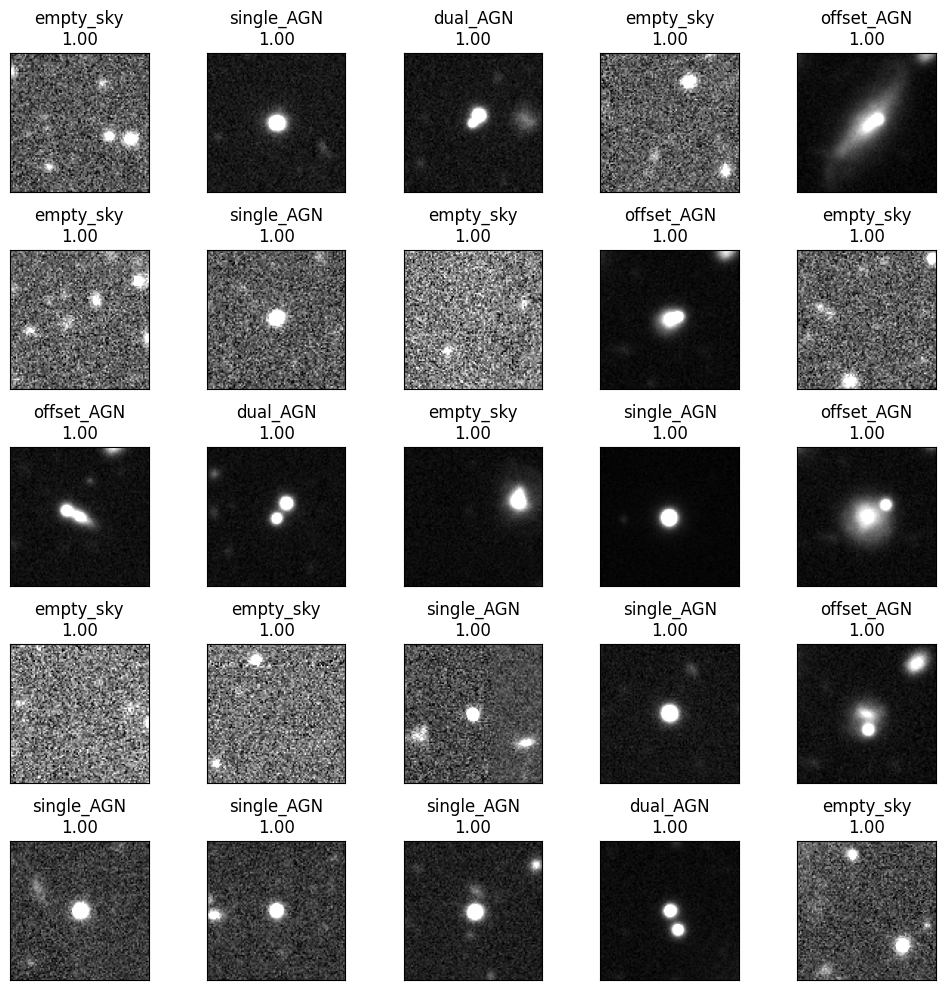

In [21]:
dual_finder_instance.predict(dual_finder_model, test_dataset)